In [6]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [7]:
#!wget -q https://github.com/1297rohit/RCNN/blob/master/Images.zip
#!unzip -qq /content/Images
#!unzip -qq /content/Airplanes_Annotations.zip
!jar xvf /content/Images.zip

  created: Images/
 inflated: Images/airplane_007.jpg
 inflated: Images/airplane_006.jpg
 inflated: Images/airplane_005.jpg
 inflated: Images/airplane_004.jpg
 inflated: Images/airplane_003.jpg
 inflated: Images/airplane_002.jpg
 inflated: Images/airplane_001.jpg
 inflated: Images/428503.jpg
 inflated: Images/428501.jpg
 inflated: Images/428492.jpg
 inflated: Images/428491.jpg
 inflated: Images/428483.jpg
 inflated: Images/428482.jpg
 inflated: Images/428481.jpg
 inflated: Images/428472.jpg
 inflated: Images/428462.jpg
 inflated: Images/428461.jpg
 inflated: Images/428452.jpg
 inflated: Images/428451.jpg
 inflated: Images/42850.jpg
 inflated: Images/42849.jpg
 inflated: Images/42848.jpg
 inflated: Images/42847.jpg
 inflated: Images/airplane_309.jpg
 inflated: Images/airplane_319.jpg
 inflated: Images/airplane_322.jpg
 inflated: Images/airplane_325.jpg
 inflated: Images/airplane_326.jpg
 inflated: Images/airplane_355.jpg
 inflated: Images/42845.jpg
 inflated: Images/airplane_354.jpg
 in

In [8]:
path = "/content/Images"
annot = "/content/Airplanes_Annotations"

In [9]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [10]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

airplane_464.jpg


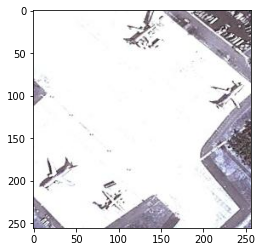

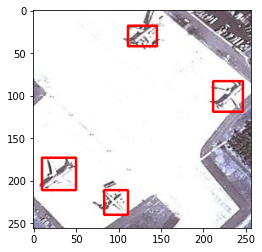

In [11]:

for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [12]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

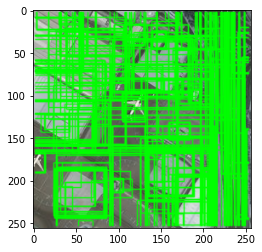

In [13]:

im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [14]:
train_images=[]
train_labels=[]

In [15]:

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [16]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


In [18]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_464.jpg
1 airplane_046.jpg
2 airplane_347.jpg
inside
3 airplane_277.jpg
4 airplane_214.jpg
inside
6 airplane_149.jpg
7 airplane_151.jpg
inside
8 airplane_695.jpg
9 airplane_425.jpg
10 airplane_460.jpg
11 airplane_673.jpg
12 airplane_465.jpg
13 airplane_348.jpg
14 airplane_007.jpg
inside
15 airplane_539.jpg
17 airplane_262.jpg
18 airplane_513.jpg
19 airplane_158.jpg
20 airplane_501.jpg
21 airplane_229.jpg
22 airplane_586.jpg
23 airplane_288.jpg
24 airplane_213.jpg
inside
25 airplane_321.jpg
26 airplane_638.jpg
inside
27 airplane_633.jpg
28 airplane_005.jpg
inside
29 airplane_523.jpg
30 airplane_308.jpg
31 airplane_128.jpg
32 airplane_252.jpg
33 airplane_582.jpg
34 airplane_663.jpg
35 airplane_502.jpg
36 airplane_255.jpg
37 airplane_396.jpg
38 airplane_030.jpg
39 airplane_477.jpg
40 airplane_590.jpg
inside
41 airplane_483.jpg
42 airplane_350.jpg
43 airplane_445.jpg
44 airplane_637.jpg
45 airplane_159.jpg
46 airplane_343.jpg
inside
47 airplane_068.jpg
48 airplane_290.jpg
49 air

In [27]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [28]:
X_new = X_new[:3000,:,:,:]
X_new.shape

(3000, 224, 224, 3)

In [30]:
y_new = y_new[:3000]
y_new.shape

(3000,)

In [31]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [32]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [33]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [34]:
from tensorflow.keras.optimizers import Adam

X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(vggmodel.input, predictions)

opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [36]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 100, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.9000
Epoch 00001: val_loss improved from inf to 0.22730, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 9s 993ms/step - loss: 0.2413 - accuracy: 0.9000 - val_loss: 0.2273 - val_accuracy: 0.8750
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.9062
Epoch 00002: val_loss did not improve from 0.22730
10/10 [==============================] - 4s 449ms/step - loss: 0.2523 - accuracy: 0.9062 - val_loss: 0.2729 - val_accuracy: 0.8438
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9467
Epoch 00003: val_loss improved from 0.22730 to 0.20258, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 12s 1s/step - loss: 0.1398 - accuracy: 0.9467 - val_loss: 0.2026 - val_accuracy: 0.9375
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.968

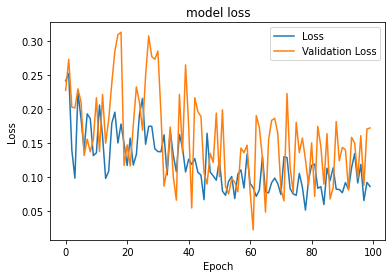

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

plane


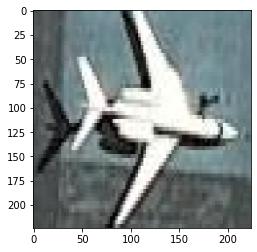

In [41]:
im = X_test[200]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

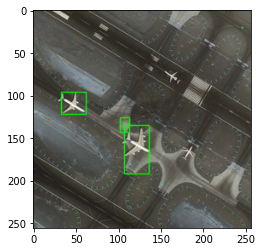

In [42]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        break